In [5]:
from drnn import DRNN
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import hp

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
expit = lambda x : np.exp(x)/(1 + np.exp(x))

def gendata_mcar(N, T, p, seed, r = 1) : 
    """ 
    Generates Gaussian data, with latent dimension r = 2

    required : N, d are both EVEN positive integers
    """
    np.random.seed(seed = seed)

    ## Data Matrix (N * T * n * d)
    Data = np.zeros( (N, T) )
    #true_Mean = np.zeros( (N, T) )
    #true_Cov = np.zeros( (N, T) )

    u_1 = np.random.uniform(-1, 1, (N, r))
    u_2 = np.random.uniform(0.2, 1, (N, r))

    v_1 = np.random.uniform(-2, 2, (T, r))
    v_2 = np.random.uniform(0.5, 2, (T, r))

    user_std = 0.3
    time_std = 0.3

    #even_ones = np.repeat([0, 1], d/2)
    #odd_ones = np.repeat([1, 0], d/2)
    #U = np.random.uniform(size=(N,r)) * user_range * 2 - user_range
    #V = np.random.uniform(size=(T,r)) * time_range * 2 - time_range
    Y0 = 1/np.sqrt(r) * np.matmul(u_1, v_1.transpose())

    a = np.random.normal(0, user_std, size=N)
    b = np.random.normal(0, time_std, size=T)
    eps = np.random.normal(0, 0.05, size=(N, T))

    # treatment effect
    # delta(i,j) = a(i) + b(t) + eps(i,t)

    aa = np.broadcast_to(a.reshape(N,1), (N,T))
    bb = np.broadcast_to(b, (N,T))
    delta = aa + bb + eps 
    Y1 = Y0 + delta 

    Y1 += np.random.normal(0, 0.001, size=(N,T))
    Y0 += np.random.normal(0, 0.001, size=(N,T))
    #D = np.stack([Y0, Y1], axis=-1)
    
    Masking = np.zeros( (N, T) )

    Masking = np.reshape(np.random.binomial(1, p, (N*T)), (N, T))

    # for sim purpose, last row, last column is observed
    Masking[N - 1, T - 1] = 1
    Data = np.zeros((N, T))
    Data[Masking == 1] = Y1[Masking == 1]
    Data[Masking == 0] = Y0[Masking == 0]


    return Data, Masking

(200, 200)

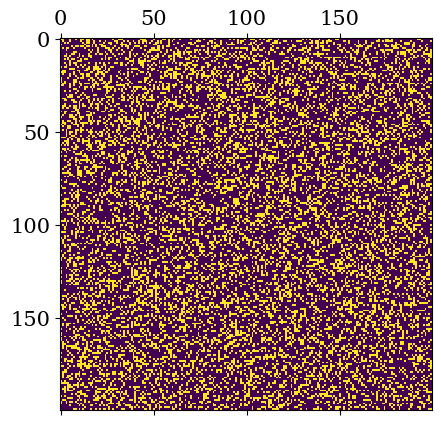

In [34]:
Z, M = gendata_mcar(200, 200, p = 0.3, seed = 42)
plt.matshow(M)
Z.shape

In [35]:
N, T = M.shape
obvs_inds = np.nonzero(M == 1)
rq_obvs_inds_x = obvs_inds[0][np.logical_and(obvs_inds[0] >= T // 2, obvs_inds[1] >= N // 2)]
rq_obvs_inds_y = obvs_inds[1][np.logical_and(obvs_inds[1] >= N // 2, obvs_inds[0] >= T // 2)]
rq_inds = (rq_obvs_inds_x, rq_obvs_inds_y)


In [71]:
import simulate_drnn

In [101]:
Z, Theta, M = simulate_drnn.gendata_nonlin_mcar(200, 200, non_lin="sinh", p = 0.5, seed = 20)

In [156]:
Z = np.load("heartsteps_data/heartsteps_data.npy", allow_pickle=True)
M = np.load("heartsteps_data/heartsteps_mask.npy", allow_pickle=True)
Z = np.sum(Z, axis = 2)
M = M[:, :200]
Z = Z[:, :200]
print(Z.shape)

(37, 200)


In [157]:
drnn_spc = {
    'row_eta': hp.uniform('row_eta', 0, 0.7),
    'col_eta': hp.uniform('col_eta', 0, 0.7)
}

mcar_drnn = DRNN(eta_space = hp.uniform('eta', 0, 0.7), drnn_eta_space=drnn_spc)
Z = np.ma.masked_array(Z, np.logical_not(M))
r_dist, c_dist = mcar_drnn.distances(Z)


In [117]:
c_dist

array([[           inf,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            inf, 10115.08680556, ...,
         7875.91435185,  6820.00694444,  4489.5625    ],
       [           nan, 10115.08680556,            inf, ...,
         7241.7662037 ,    22.02777778,  3650.03125   ],
       ...,
       [           nan,  7875.91435185,  7241.7662037 , ...,
                   inf, 10476.80902778,  3912.07638889],
       [           nan,  6820.00694444,    22.02777778, ...,
        10476.80902778,            inf,  2704.91319444],
       [           nan,  4489.5625    ,  3650.03125   , ...,
         3912.07638889,  2704.91319444,            inf]])

In [160]:
np.quantile(c_dist[~np.isinf(c_dist) & ~np.isnan(c_dist)], q = [0.75, 0.9, 0.95])

array([1507916.5  , 2934270.5  , 4223762.265])

In [62]:
eta_drnn_col

np.float64(0.0)

In [63]:
eta_drnn_row

np.float64(0.2)

In [92]:
def gendata_mcar(N, T, p, seed, r = 4) : 
    """ 
    Generates Gaussian data, with latent dimension r = 4
    """
    np.random.seed(seed = seed)

    ## Data Matrix (N * T * n * d)
    Data = np.zeros( (N, T) )
    #true_Mean = np.zeros( (N, T) )
    #true_Cov = np.zeros( (N, T) )

    user_range = 0.9
    time_range = 0.9

    user_std = 0.3
    time_std = 0.3

    U = np.random.uniform(size=(N,r)) * user_range * 2 - user_range
    V = np.random.uniform(size=(T,r)) * time_range * 2 - time_range
    Y0 = 1/np.sqrt(r) * np.matmul(U, V.transpose())

    a = np.random.normal(0, user_std, size=N)
    b = np.random.normal(0, time_std, size=T)
    eps = np.random.normal(0, 0.05, size=(N, T))

    # treatment effect
    # delta(i,j) = a(i) + b(t) + eps(i,t)

    aa = np.broadcast_to(a.reshape(N,1), (N,T))
    bb = np.broadcast_to(b, (N,T))
    delta = aa + bb + eps 
    Y1 = Y0 + delta 

    Y1 += np.random.normal(0, 0.001, size=(N,T))
    Y0 += np.random.normal(0, 0.001, size=(N,T))
    #D = np.stack([Y0, Y1], axis=-1)
    
    Masking = np.zeros( (N, T) )

    Masking = np.reshape(np.random.binomial(1, p, (N*T)), (N, T))

    # for sim purpose, last row, last column is observed
    Masking[N - 1, T - 1] = 1
    Data = np.zeros((N, T))
    Data[Masking == 1] = Y1[Masking == 1]
    Data[Masking == 0] = Y0[Masking == 0]

    return Data, Masking

In [68]:
rq_inds = (N - 1, T - 1)
eval_mask = np.logical_not(M)
eval_mask[rq_inds] = 1

masked_Z = np.ma.masked_array(Z, eval_mask)

eta_drnn_row, eta_drnn_col = mcar_drnn.search_eta_drnn(masked_Z, M, max_evals = 100)
eta_star_row = mcar_drnn.search_eta_snn(masked_Z, M, nn_type = "u", max_evals=100)
eta_star_col = mcar_drnn.search_eta_snn(masked_Z, M, nn_type = "i", max_evals=100)



row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
flattened_inds = [rq_inds]
# for b in range(len(rq_inds[0])):
#   flattened_inds.append((rq_inds[0][b], rq_inds[1][b]))
est = mcar_drnn.estimate(masked_Z, M, eta_drnn_row, eta_drnn_col, flattened_inds, row_dists, col_dists)
truth = Z[rq_inds]
err = mcar_drnn.avg_error(est[rq_inds], truth)
snn_unit_est = mcar_drnn.snn_estimate(masked_Z, M, eta_star_row, flattened_inds, row_dists, "u")
snn_time_est = mcar_drnn.snn_estimate(masked_Z, M, eta_star_col, flattened_inds, col_dists, nn_type = "i")
unit_err = mcar_drnn.avg_error(snn_unit_est[rq_inds], truth)
time_err = mcar_drnn.avg_error(snn_time_est[rq_inds], truth)

print(err)
print(unit_err)
print(time_err)


0.005996660400794241
0.08786652522877604
0.26356716237220656


In [26]:
row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
flattened_inds = []
for b in range(len(rq_inds[0])):
  flattened_inds.append((rq_inds[0][b], rq_inds[1][b]))
est = mcar_drnn.estimate(masked_Z, M, eta_star_row, eta_star_col, flattened_inds, row_dists, col_dists)
truth = Z[rq_inds]
err = mcar_drnn.avg_error(est[rq_inds], truth)

here
here
here
here
here


In [111]:
Z = np.array([[1, 2, 3, 4], [0, 2, 4, 3], [1, 2, 5, 1], [1, 2, 3, 100]])
M = np.array([[1, 0, 1, 0], [1, 1, 1, 1], [0, 1, 0, 0], [1, 1, 1, 0]])
act_M = np.logical_not(M)
Z_m = np.ma.masked_array(Z, mask = act_M)
row_dists, col_dists = mcar_drnn.distances(Z_m, M = None)
#row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
est = mcar_drnn.estimate(Z_m, M, 0, 1, [(3, 3)], row_dists, col_dists)

[True False True False]
[False  True  True False]
--
[[--]
 [3]
 [--]
 [--]]
[1 2 3 --]


In [107]:
row_dists[3]

masked_array(data=[0.0, 0.6666666666666666, 0.0, inf],
             mask=[False, False, False, False],
       fill_value=1e+20)

In [109]:
est

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan,  3.]])

In [44]:
test_Z = np.array([[1, 2, 3], [4, 5, 6]])
mask = np.array([[1, 0, 1], [1, 0, 1]])
m_test_Z = np.ma.masked_array(test_Z, np.logical_not(mask))
mcar_drnn.distances(m_test_Z)

(masked_array(
   data=[[inf, 9.0],
         [9.0, inf]],
   mask=[[False, False],
         [False, False]],
   fill_value=1e+20),
 masked_array(
   data=[[inf, --, 4.0],
         [--, inf, --],
         [4.0, --, inf]],
   mask=[[False,  True, False],
         [ True, False,  True],
         [False,  True, False]],
   fill_value=1e+20))

In [37]:
row_dists, col_dists = mcar_drnn.distances(masked_Z, M = None)
flattened_inds = []
for b in range(len(rq_inds[0])):
  flattened_inds.append((rq_inds[0][b], rq_inds[1][b]))
est = mcar_drnn.estimate(masked_Z, M, eta_star_row, eta_star_col, flattened_inds, row_dists, col_dists)
est[rq_inds]

c:\Users\Caleb\HeartstepsDNN\DRNN\drnn.py:109: UserWarning: Warning: converting a masked element to nan.
  ests[i, j] = np.mean(row_Ys - col_Ys + Z[s_unit_nn][s_time_nn]) # this is len(s_unit_nn) x len(s_time_nn)


array([ 0.15819007, -0.13098725, -0.97126471, ..., -0.70994375,
       -0.77141201, -0.74979711])

In [149]:
# new ssplit
direc = "."
drnn_err = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_abs_err.npy")
drnn_eta = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_abs_eta.npy")
unit_err = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_unit_abs_err.npy")
unit_eta = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_unit_abs_eta.npy")
time_err = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_time_abs_err.npy")
time_eta = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_time_abs_eta.npy")
usvt_err = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_usvt_abs_err.npy")

drnn_ests = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_estimates.npy", allow_pickle=True)
unit_ests = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_unit_estimates.npy", allow_pickle=True)
time_ests = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_time_estimates.npy", allow_pickle=True)
usvt_ests = np.load(direc + "/drnn_full_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_usvt_estimates.npy", allow_pickle=True)


In [186]:
ssplit_direc = "."
drnn_err_ssplit = np.load(ssplit_direc + "/drnn_exp2_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_abs_err.npy")
drnn_err_full = np.load(ssplit_direc + "/drnn_exp2_sinh_full_mcar_N4_7_nonlin_uv11_d4_p5_abs_err.npy")
unit_err_ssplit = np.load(ssplit_direc + "/drnn_exp2_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_unit_abs_err.npy")
unit_err_full = np.load(ssplit_direc + "/drnn_exp2_sinh_full_mcar_N4_7_nonlin_uv11_d4_p5_unit_abs_err.npy")
time_err_ssplit = np.load(ssplit_direc + "/drnn_exp2_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_time_abs_err.npy")
time_err_full = np.load(ssplit_direc + "/drnn_exp2_sinh_full_mcar_N4_7_nonlin_uv11_d4_p5_time_abs_err.npy")

drnn_eta_ssplit = np.load(ssplit_direc + "/drnn_exp2_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_abs_eta.npy")
drnn_eta_full = np.load(ssplit_direc + "/drnn_exp2_sinh_full_mcar_N4_7_nonlin_uv11_d4_p5_abs_eta.npy")
unit_eta_ssplit = np.load(ssplit_direc + "/drnn_exp2_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_unit_abs_eta.npy")
unit_eta_full = np.load(ssplit_direc + "/drnn_exp2_sinh_full_mcar_N4_7_nonlin_uv11_d4_p5_unit_abs_eta.npy")
time_eta_ssplit = np.load(ssplit_direc + "/drnn_exp2_sinh_ssplit_mcar_N4_7_nonlin_uv11_d4_p5_time_abs_eta.npy")
time_eta_full = np.load(ssplit_direc + "/drnn_exp2_sinh_full_mcar_N4_7_nonlin_uv11_d4_p5_time_abs_eta.npy")

In [171]:
ssplit_direc = "./ssplit_results"
drnn_err_ssplit = np.load(ssplit_direc + "/drnn_exp2_bug_ssplit_mcar_N4_7_blin_uv11_d4_p5_abs_err.npy")
drnn_err_full = np.load(ssplit_direc + "/drnn_exp2_bug_full_mcar_N4_7_blin_uv11_d4_p5_abs_err.npy")
unit_err_ssplit = np.load(ssplit_direc + "/drnn_exp2_bug_ssplit_mcar_N4_7_blin_uv11_d4_p5_unit_abs_err.npy")
unit_err_full = np.load(ssplit_direc + "/drnn_exp2_bug_full_mcar_N4_7_blin_uv11_d4_p5_unit_abs_err.npy")
time_err_ssplit = np.load(ssplit_direc + "/drnn_exp2_bug_ssplit_mcar_N4_7_blin_uv11_d4_p5_time_abs_err.npy")
time_err_full = np.load(ssplit_direc + "/drnn_exp2_bug_full_mcar_N4_7_blin_uv11_d4_p5_time_abs_err.npy")

drnn_eta_ssplit = np.load(ssplit_direc + "/drnn_exp2_bug_ssplit_mcar_N4_7_blin_uv11_d4_p5_abs_eta.npy")
drnn_eta_full = np.load(ssplit_direc + "/drnn_exp2_bug_full_mcar_N4_7_blin_uv11_d4_p5_abs_eta.npy")
unit_eta_ssplit = np.load(ssplit_direc + "/drnn_exp2_bug_ssplit_mcar_N4_7_blin_uv11_d4_p5_unit_abs_eta.npy")
unit_eta_full = np.load(ssplit_direc + "/drnn_exp2_bug_full_mcar_N4_7_blin_uv11_d4_p5_unit_abs_eta.npy")
time_eta_ssplit = np.load(ssplit_direc + "/drnn_exp2_bug_ssplit_mcar_N4_7_blin_uv11_d4_p5_time_abs_eta.npy")
time_eta_full = np.load(ssplit_direc + "/drnn_exp2_bug_full_mcar_N4_7_blin_uv11_d4_p5_time_abs_eta.npy")

In [86]:
drnn_eta = np.load(direc + "/drnn_tstfull_allssplit_mcar_N4_6_blin_uv0505_d4_p5_abs_eta.npy")


In [128]:
np.mean(unit_err, axis = 1)

array([0.58334331, 0.51026685, 0.36451676, 0.25535981])

In [129]:
np.mean(drnn_err, axis = 1)

array([0.59629314, 0.52097763, 0.37252062, 0.2614577 ])

In [137]:
np.mean(drnn_eta, axis = 1)

array([[1.17369338, 1.18288996, 2.16014511, 2.18144686],
       [0.95202728, 0.95407296, 1.15761767, 1.30148671],
       [0.89096954, 0.73873698, 1.33687721, 2.00807019],
       [0.51899416, 0.50244401, 1.4754485 , 2.13742373]])

In [141]:
drnn_eta

array([[[0.48477373, 0.52993311, 1.99320253, 3.39528334],
        [1.87479102, 2.3831587 , 2.11530733, 2.79882302],
        [1.0313591 , 0.27984224, 0.88752728, 0.49503768],
        [0.35888485, 1.83820578, 3.24582022, 3.12300321],
        [2.11865819, 0.88330997, 2.55886817, 1.09508704]],

       [[1.46746326, 0.20906216, 0.20456911, 0.33602022],
        [0.97855856, 0.75323881, 0.1239648 , 1.46996638],
        [0.75458741, 0.65154012, 3.01345843, 1.58919638],
        [0.92522597, 0.56487795, 1.1915426 , 1.47901811],
        [0.63430118, 2.59164577, 1.2545534 , 1.63323247]],

       [[2.27514771, 0.51896366, 2.49397128, 3.037922  ],
        [0.52125487, 0.73516745, 2.32854   , 2.48907034],
        [0.41798917, 0.91120136, 0.09081899, 2.62711624],
        [0.50024703, 0.96652235, 0.50725847, 1.04454446],
        [0.74020893, 0.56183007, 1.26379731, 0.84169791]],

       [[0.51553991, 0.51090423, 3.43899559, 2.39551961],
        [0.45987483, 0.47580789, 2.13304228, 3.13987838],
        

In [138]:
np.mean(unit_eta, axis = 1)

array([[0.62908626, 0.77658845],
       [0.38186962, 0.47198082],
       [0.47658582, 0.47204272],
       [0.32298907, 0.37206458]])

In [143]:
time_eta

array([[[5.29946585e-01, 3.23444633e+00],
        [3.17946282e-01, 3.42366107e+00],
        [2.82586238e-02, 6.08516679e-01],
        [5.47535388e-01, 2.39163640e+00],
        [4.81439018e-04, 1.00715543e+00]],

       [[2.32468806e-01, 5.09115792e-01],
        [7.37343817e-01, 4.73060127e-01],
        [5.95654418e-01, 3.49034630e+00],
        [4.34468897e-01, 4.52534849e-01],
        [4.86160541e-01, 3.19138031e+00]],

       [[4.26549996e-01, 5.20221359e-01],
        [4.39976154e-01, 1.97041205e+00],
        [6.49141375e-01, 2.90420582e+00],
        [3.22322810e-01, 2.97685848e-01],
        [3.36074191e-01, 1.06918058e+00]],

       [[2.95304882e-01, 1.91250587e+00],
        [3.50195684e-01, 9.05763107e-01],
        [3.51178737e-01, 1.78867813e+00],
        [4.27031590e-01, 2.30570329e+00],
        [4.00393062e-01, 1.80818942e+00]]])

In [144]:
np.mean(time_eta, axis = 1)

array([[0.28483366, 2.13308318],
       [0.4972193 , 1.62328748],
       [0.43481291, 1.35234113],
       [0.36482079, 1.74416796]])

In [91]:
# lin
direc = "experimental_results"
drnn_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_abs_err.npy")
drnn_eta = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_abs_eta.npy")
unit_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_unit_abs_err.npy")
unit_eta = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_unit_abs_eta.npy")
time_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_time_abs_err.npy")
time_eta = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_time_abs_eta.npy")
usvt_err = np.load(direc + "/drnn_mcar_N4_7_p5_blin_uv11_d2_usvt_abs_err.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'experimental_results/drnn_mcar_N4_7_p5_blin_uv11_d2_abs_err.npy'

In [92]:
# non lin
direc = "experimental_results"
drnn_err = np.load(direc + "/drnn_mcar_N4_7_p5_nonlin_cube_uv11_d2_abs_err.npy")
drnn_eta = np.load(direc + "/drnn_mcar_N4_7_p5_nonlin_cube_uv11_d2_abs_eta.npy")
unit_err = np.load(direc + "/drnn_mcar_N4_7_p5_nonlin_cube_uv11_d2_unit_abs_err.npy")
unit_eta = np.load(direc + "/drnn_mcar_N4_7_p5_nonlin_cube_uv11_d2_unit_abs_eta.npy")
time_err = np.load(direc + "/drnn_mcar_N4_7_p5_nonlin_cube_uv11_d2_time_abs_err.npy")
time_eta = np.load(direc + "/drnn_mcar_N4_7_p5_nonlin_cube_uv11_d2_time_abs_eta.npy")
usvt_err = np.load(direc + "/drnn_mcar_N4_7_p5_nonlin_cube_uv11_d2_usvt_abs_err.npy")

In [116]:
unit_err

array([[0.56074523, 0.8229308 , 0.69174121, 0.31605499, 1.03667909],
       [0.53438614, 0.23276823, 0.30157009, 0.72262664, 0.41561184],
       [0.1914433 , 0.26303736, 0.33106312, 0.31686119, 0.21154664],
       [0.15869691, 0.12645151, 0.09101969, 0.12181339, 0.24852184]])

In [267]:
unit_err

array([[0.19049707, 0.44274251, 0.7359814 , 0.06691642, 0.25980295],
       [0.14018141, 0.23519809, 0.09672301, 0.23492119, 0.31464201],
       [0.10535198, 0.21144758, 0.30424297, 0.1759658 , 0.12380815]])

In [252]:
np.mean(usvt_err, axis = 1)

array([0.27203086, 0.29372164, 0.22382277, 0.31656219])

In [170]:
np.mean(usvt_none_err, axis = 1)

array([0.23176358, 0.30861153, 0.20899622, 0.32505002])

In [168]:
print(np.mean(usvt_err, axis = 1))

[0.22577931 0.30861153 0.20899622 0.32505002]


In [133]:
drnn_eta.shape 

(4, 30, 4)

In [13]:
print(np.mean(drnn_eta, axis = 1))
print(np.mean(unit_eta, axis = 1))
print(np.mean(time_eta, axis = 1))

[[1.21202327 1.72038337 1.05186363 0.47142047]
 [1.30233673 0.5656082  1.25453764 1.2805699 ]
 [1.30945068 0.4134702  0.58996783 0.68338556]
 [0.49650033 0.43555955 0.45211414 0.55215298]]
[[0.38724724 0.6486456 ]
 [0.31654267 0.50404757]
 [0.42485885 0.46680863]
 [0.35220573 0.3587671 ]]
[[0.92112817 0.63361082]
 [0.61510873 0.62741825]
 [0.34862493 0.42324837]
 [0.38929375 0.3595986 ]]


In [151]:
time_err.shape

(4, 30)

In [139]:
print(drnn_err[1])
print(unit_err[1])
print(time_err[1])

[2.42934940e-03 1.29768672e-02 4.65932916e-02 1.78040996e-01
 1.44929294e-01 1.45246665e-01 1.84626136e-01 7.60284072e-02
 1.29660094e-02 5.53312483e-01 2.64749810e-01 7.64822701e-04
 1.99153924e-02 2.24774452e-01 3.96110555e-01 6.04077505e-06
 2.16726590e-01 2.46072400e-01 1.01351652e-01 6.47672142e-03
 1.20048046e-01 7.46675163e-05 1.52899070e-01 1.68927305e-02
 1.28290930e-02 7.62160529e-03 4.53408707e-02 4.33406508e-02
 1.32820265e-01 2.21248150e-01]
[2.06139398e-02 5.59055190e-02 1.02070369e-01 3.77911628e-02
 4.07020568e-01 2.37245992e-02 8.09593070e-02 1.12080865e-04
 3.10315843e-03 5.14213356e-01 1.61391339e-02 1.38465802e-02
 2.96174447e-02 2.25622341e-01 3.38360359e-02 1.42661439e-03
 3.54536217e-01 6.83388165e-01 4.28009166e-01 1.05633689e-01
 5.22571505e-02 5.16358514e-02 2.53199438e-01 8.04085611e-05
 1.48270261e-01 4.55968018e-02 3.11504218e-03 8.02514112e-03
 2.63075629e-01 1.23216247e-01]
[2.20998722e-01 1.43983217e-01 6.00814466e-02 1.79526352e-01
 6.95949280e-02 8.352

In [12]:
np.std(drnn_err, axis =1)
np.std(unit_err, axis = 1)
np.std(time_err, axis = 1)

array([0.15799558, 0.13483996, 0.09176727, 0.10257828])

In [228]:
usvt_err

array([[2.32266766e-01, 4.34600401e-01, 5.97453611e-01, 1.04824433e-01,
        1.42354041e-01, 1.25777377e-01, 1.93258314e-01, 1.09489100e-01,
        8.18878380e-02, 1.00930604e-01, 8.69216102e-02, 6.42165385e-03,
        1.60874612e-01, 5.51877229e-01, 5.24522760e-01, 2.78002338e-01,
        4.23078037e-01, 4.85445380e-01, 2.49379953e-02, 7.75146770e-02,
        1.24383424e-05, 2.10947591e-01, 2.60071157e-01, 5.65432155e-01,
        1.03149644e-01, 1.38031260e-01, 3.00617030e-02, 1.63203784e-01,
        4.17791461e-01, 9.21942740e-02],
       [1.04116040e-01, 1.09071714e-01, 1.38949257e-01, 4.62974814e-01,
        3.98327684e-01, 2.55227742e-01, 1.50816793e-01, 1.27219361e-01,
        1.37099487e-01, 7.43751037e-01, 1.69196179e-01, 1.06883168e-01,
        3.61920098e-01, 7.40038723e-02, 7.05857467e-02, 3.47871045e-01,
        1.92285476e-01, 3.39861474e-01, 1.51310356e-01, 9.04896988e-01,
        3.09281830e-01, 6.04386145e-02, 6.27526857e-01, 2.15438684e-01,
        2.14766785e-01,

In [117]:
_eta

array([[0.07946436, 0.25661346, 0.0116677 , 0.23973342, 0.18415741],
       [0.27480137, 0.14236181, 0.29941581, 0.01302101, 0.22232017],
       [0.26547061, 0.29813501, 0.29791452, 0.2686998 , 0.28145807],
       [0.2998253 , 0.29996293, 0.28981846, 0.29988363, 0.26329515]])

In [11]:
import matplotlib as mpl

In [173]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('axes', axisbelow=True)
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = label_size
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size


lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
mss = ['x', 'o', '>', 's', 'D', '>', 'D', '>', 's', 'o', 'D']


/var/folders/51/5b2yypxn6qj7ntrpl0x8kcvm0000gn/T/ipykernel_5038/3521491702.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.errorbar(T_values, TimeNN_errors, yerr=tnn_stderr, fmt='s', color = "orange", marker='s', linestyle='None', markersize=12, label=rf'Time-NN: $T^{{{tnn_slope:.2f}}}$')


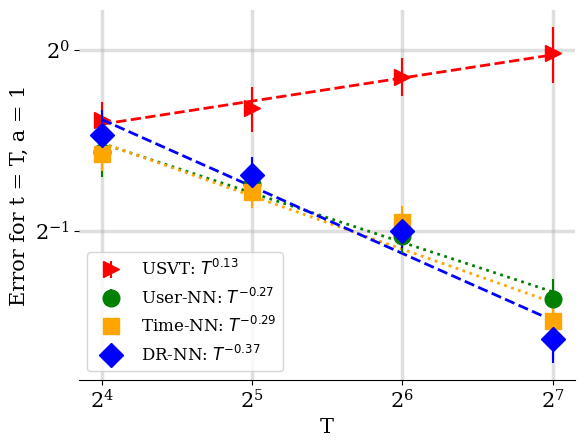

In [137]:
    import numpy as np
    import matplotlib.pyplot as plt

    # Define T values and corresponding error rates for each method
    T_values = np.array([2**4, 2**5, 2**6, 2**7])

    # USVT_errors = 2**-3 * T_values**-0.10
    UserNN_errors = np.nanmean(unit_err, axis = 1)
    TimeNN_errors = np.nanmean(time_err, axis = 1)
    DRNN_errors = np.nanmean(drnn_err, axis = 1)
    USVT_errors = np.nanmean(usvt_err, axis = 1)

    unn_stderr = np.nanstd(unit_err, axis = 1) / np.sqrt(unit_err.shape[1])
    tnn_stderr = np.nanstd(time_err, axis = 1) / np.sqrt(time_err.shape[1])
    drnn_stderr = np.nanstd(drnn_err, axis = 1) / np.sqrt(drnn_err.shape[1])
    usvt_stderr = np.nanstd(usvt_err, axis = 1) / np.sqrt(usvt_err.shape[1])



    # Create the plot
    plt.figure()
    #plt.plot(T_values, USVT_errors, 'r', linestyle='-', marker='D', markersize=8, linewidth=2, label=r'USVT: $T^{-0.46}$')

    def add_regression_line(x, y, color, label, linestyle):
        # Fit a line to log-transformed data
        slope, intercept = np.polyfit(np.log2(x), np.log2(y), 1)
        plt.plot(x, 2**(intercept) * x**slope, color=color, linestyle=linestyle, linewidth=2) 
                #label=f"{label} (slope: {slope:.2f})")
        return slope

    usvt_slope = add_regression_line(T_values, USVT_errors, 'red', 'USVT', '--')
    unn_slope = add_regression_line(T_values, UserNN_errors, 'green', 'User-NN', ':')
    tnn_slope = add_regression_line(T_values, TimeNN_errors, 'orange', 'Time-NN', ':')
    drnn_slope = add_regression_line(T_values, DRNN_errors, 'blue', 'DR-NN', '--')

    # Plot each method with corresponding markers, colors, and line styles
    plt.errorbar(T_values, USVT_errors, yerr=usvt_stderr, fmt = 'r', marker='>', markersize=12, linestyle='None', barsabove=True, label=rf'USVT: $T^{{{usvt_slope:.2f}}}$')
    plt.errorbar(T_values, UserNN_errors, yerr=unn_stderr, fmt = 'g', marker='o', markersize=12, linestyle='None', label=rf'User-NN: $T^{{{unn_slope:.2f}}}$')
    plt.errorbar(T_values, TimeNN_errors, yerr=tnn_stderr, fmt='s', color = "orange", marker='s', linestyle='None', markersize=12, label=rf'Time-NN: $T^{{{tnn_slope:.2f}}}$')
    plt.errorbar(T_values, DRNN_errors, fmt='bD', yerr=drnn_stderr, markersize=12, linestyle="None", label=rf'DR-NN: $T^{{{drnn_slope:.2f}}}$')

    # Logarithmic scale for both axes
    plt.xscale('log', base=2)
    plt.yscale('log', base=2)

    # Axis labels
    plt.xlabel(r'T', fontsize=15)
    plt.ylabel(r'Error for t = T, a = 1', fontsize=15)

    # Title
    #plt.title(r'Decay of avg. error across users (N = T, 30 trials)', fontsize=16)

    # Add legend
    plt.legend(fontsize=12)

    # Grid for better readability
    #plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax1 = plt.gca()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.grid(True, alpha=0.4)


    # Show the plot#
    plt.savefig("drnn_mcar_nonlin_sinh_uv11_abserr_decay2_4_7.pdf", bbox_inches = "tight")


In [289]:
np.mean(usvt_err, axis = 1)

array([0.27203086, 0.29372164, 0.22382277, 0.31656219])

In [26]:
usvt_errs = np.load('drnn_mcar_N128_tryabs_usvt_errors.npy')
user_nn_errs = np.load('drnn_mcar_N128_abs_unit_errors.npy')
time_nn_errs = np.load('drnn_mcar_N128_abs_time_errors.npy')
drnn_errs = np.load('drnn_mcar_N128_abs_drnn_errors.npy')

In [191]:
usvt_errs.shape

(28,)

In [302]:
usvt_errs

array([2.16184339e-01, 5.43714437e-01, 3.91585739e-01, 2.64486704e-01,
       4.89581357e-02, 8.93613081e-02, 3.33265621e-01, 8.47672345e-01,
       9.24952951e-02, 3.23889493e-01, 2.10114779e-01, 7.98956839e-01,
       1.45061208e+00, 4.98453656e-03, 1.40218029e-01, 9.43763697e-01,
       1.38451395e-02, 1.35431420e-02, 5.12074001e-03, 5.02384478e-03,
       1.49401358e-01, 1.29671857e+00, 1.47994707e+00, 4.96969595e-02,
       5.41559944e-01, 1.72945506e-01, 4.44640616e-01, 5.54406406e-02,
       7.15755927e-02, 2.39419671e-01, 4.91525406e-01, 1.01961532e-02,
       3.72377823e-01, 1.43246220e-02, 5.72391323e-01, 3.62975605e-02,
       2.59172107e-02, 9.00277441e-03, 2.63918833e-01, 9.98676641e-04,
       3.77674766e-01, 8.37615885e-02, 3.62180426e-01, 4.50930714e-01,
       4.97925063e-01, 3.51285049e-01, 1.85415633e+00, 8.51979237e-02,
       6.87054363e-03, 9.22390308e-03, 2.01115093e-03, 9.47036994e-01,
       3.05270128e-01, 3.60161328e-01, 6.12174940e-01, 1.73072373e-01,
      

In [167]:
drnn_errs = np.load('heartsteps_a1_drnn_err.npy')
user_nn_errs = np.load('heartsteps_a1_unit_err.npy')
time_nn_errs = np.load('heartsteps_a1_time_err.npy')
usvt_errs = np.load('heartsteps_a1_usvt_err.npy')

In [165]:
drnn_errs = np.load('heartsteps_a0_drnn_err.npy')
user_nn_errs = np.load('heartsteps_a0_unit_err.npy')
time_nn_errs = np.load('heartsteps_a0_time_err.npy')
usvt_errs = np.load('heartsteps_a0_usvt_err.npy')

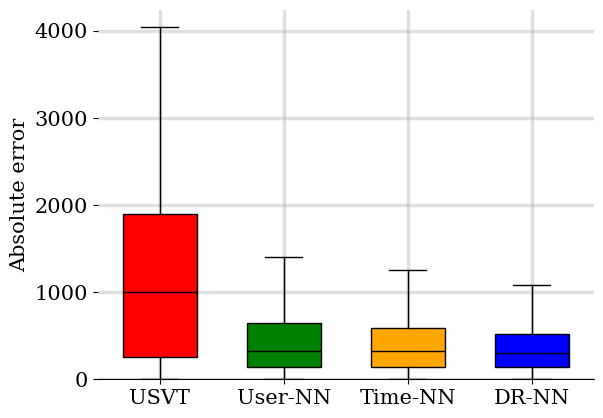

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
usvt_data = usvt_errs  # Replace with your actual USVT data
user_nn_data = user_nn_errs  # Replace with your actual User-NN data
time_nn_data = time_nn_errs # Replace with your actual Time-NN data
dr_nn_data = drnn_errs  # Replace with your actual DR-NN data

# Combine data into a list for plotting
data = [usvt_data, user_nn_data, time_nn_data, dr_nn_data]

# Set up the plot
plt.figure()

# Create boxplot
box = plt.boxplot(data, patch_artist=True, widths=0.6, showfliers=False)

# Customizing colors for each boxplot
colors = ['red', 'green', 'orange', 'blue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')  
# Set y-axis limit
#plt.ylim(0, 0.4)
plt.ylim(0, None)

# Add labels and title
plt.xticks([1, 2, 3, 4], ['USVT', 'User-NN', 'Time-NN', 'DR-NN'], fontsize=15)
plt.ylabel(r'Absolute error', fontsize=15)
#plt.title(r'Variation of error across users  $(N = T = 128, \; 1 \; \text{Trial})$', fontsize=20)

ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(True, alpha=0.4)

plt.xlabel(r'', fontsize=15)

# Customize grid lines
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Show the plot
plt.savefig("drnn_variation_abs_error_heartsteps_a1.pdf", bbox_inches = "tight")

In [15]:
import pandas as pd

In [17]:
unit_err_ssplit.shape

(4, 30)

In [151]:
error_array = drnn_err_ssplit

matrix_sizes = ["$2^4$", "$2^5$", "$2^6$", "$2^7$"]

# Create a DataFrame
df_drnn_ssplit_errors = pd.DataFrame({
    'Matrix Size': np.repeat(matrix_sizes, drnn_err_ssplit.shape[1]),
    'Error': drnn_err_ssplit.flatten()
})
df_drnn_ssplit_errors["split"] = "ssplit"

df_drnn_full_errors = pd.DataFrame({
    'Matrix Size': np.repeat(matrix_sizes, drnn_err_full.shape[1]),
    'Error': drnn_err_full.flatten()
})
df_drnn_full_errors["split"] = "full"

df_drnn_errors = pd.concat([df_drnn_ssplit_errors, df_drnn_full_errors])
df_drnn_errors

,Matrix Size,Error,split
0,$2^4$,0.425218,ssplit
1,$2^4$,0.332189,ssplit
2,$2^4$,0.452604,ssplit
3,$2^4$,0.625190,ssplit
4,$2^4$,0.514831,ssplit
...,...,...,...
115,$2^7$,0.022725,full
116,$2^7$,0.059002,full
117,$2^7$,0.147974,full
118,$2^7$,0.109794,full


In [ ]:
import seaborn as sns

In [100]:
np.mean(drnn_eta_ssplit, axis =1)

array([[18.89242803, 22.91145813],
       [21.24012396, 22.15536604],
       [14.39937202, 16.563619  ],
       [ 7.26617431, 13.89849799]])

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/51/5b2yypxn6qj7ntrpl0x8kcvm0000gn/T/ipykernel_5038/373824958.py:3: SyntaxWarning: invalid escape sequence '\m'
  matrix_sizes = ["$\mathdefault{2^4}$", "$\mathdefault{2^5}$", "$\mathdefault{2^6}$", "$\mathdefault{2^7}$"]
/var/folders/51/5b2yypxn6qj7ntrpl0x8kcvm0000gn/T/ipykernel_5038/373824958.py:3: SyntaxWarning: invalid escape sequence '\m'
  matrix_sizes = ["$\mathdefault{2^4}$", "$\mathdefault{2^5}$", "$\mathdefault{2^6}$", "$\mathdefault{2^7}$"]
/var/folders/51/5b2yypxn6qj7ntrpl0x8kcvm0000gn/T/ipykernel_5038/373824958.py:3: SyntaxWarning: invalid escape sequence '\m'
  matrix

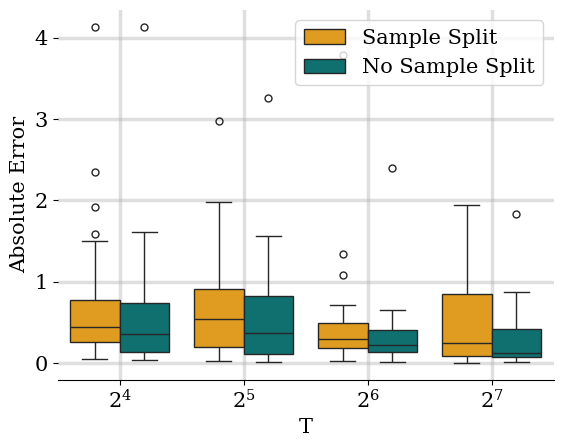

In [187]:
error_array = drnn_err_ssplit

matrix_sizes = ["$\mathdefault{2^4}$", "$\mathdefault{2^5}$", "$\mathdefault{2^6}$", "$\mathdefault{2^7}$"]

# Create a DataFrame
df_drnn_ssplit_errors = pd.DataFrame({
    'Matrix Size': np.repeat(matrix_sizes, drnn_err_ssplit.shape[1]),
    'Error': drnn_err_ssplit.flatten()
})
df_drnn_ssplit_errors["split"] = "ssplit"

df_drnn_full_errors = pd.DataFrame({
    'Matrix Size': np.repeat(matrix_sizes, drnn_err_full.shape[1]),
    'Error': drnn_err_full.flatten()
})
df_drnn_full_errors["split"] = "full"

df_drnn_errors = pd.concat([df_drnn_ssplit_errors, df_drnn_full_errors])

fig, ax1 = plt.subplots()
flierprops = dict(marker='o', markersize=5, linestyle='none', color='grey')
palette = {'ssplit': 'orange', 'full': 'teal'}  # Replace with your actual categories and desired colors
#palette = [cb_palette[3], cb_palette[2]]
sns.boxplot(df_drnn_errors, x='Matrix Size', y='Error', hue='split', ax=ax1, flierprops=flierprops, palette=palette)
for patch in ax1.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))  # Set alpha to 0.5 for 50% transparency
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(True, alpha=0.4)
ax1.set_xlabel('T')
#ax1.set_ylabel(r"$|\hat{\theta}_{1, 1} - \theta_{1, 1}|$", fontsize=15)
ax1.set_ylabel("Absolute Error")
# fmt = mpl.ticker.StrMethodFormatter("{x}")
# ax1.xaxis.set_major_formatter(fmt)
# ax1.yaxis.set_major_formatter(fmt)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, ['Sample Split', 'No Sample Split'], title='')
#plt.xscale('log', base=2)

plt.savefig("drnn_ssplit_exp_nonlin_sinh.pdf", bbox_inches = "tight")

In [ ]:
# Define the sizes of the matrices
matrix_sizes = [2**4, 2**5, 2**6, 2**7]

# Combine the data into a list for plotting
UserNN_ssplit_errors = np.nanmean(unit_ssplit_err, axis = 1)
TimeNN_ssplit_errors = np.nanmean(time_ssplit_err, axis = 1)
DRNN_ssplit_errors = np.nanmean(drnn_ssplit_err, axis = 1)

unn_ssplit_stderr = np.nanstd(unit_ssplit_err, axis = 1) / np.sqrt(unit_ssplit_err.shape[1])
tnn_ssplit_stderr = np.nanstd(time_ssplit_err, axis = 1) / np.sqrt(time_ssplit_err.shape[1])
drnn_ssplit_stderr = np.nanstd(drnn_ssplit_err, axis = 1) / np.sqrt(drnn_err.shape[1])
usvt_stderr = np.nanstd(usvt_err, axis = 1) / np.sqrt(usvt_err.shape[1])
# Set up the plot
plt.figure(figsize=(10, 6))

# Create boxplots for full DRNN
box_full = plt.boxplot(data_full, positions=np.array(range(len(data_full)))*2.0-0.4, widths=0.6, patch_artist=True, showfliers=False)

# Create boxplots for ssplit DRNN
box_ssplit = plt.boxplot(data_ssplit, positions=np.array(range(len(data_ssplit)))*2.0+0.4, widths=0.6, patch_artist=True, showfliers=False)

# Customizing colors for each boxplot
colors_full = 'blue'
colors_ssplit = 'green'

for patch in box_full['boxes']:
    patch.set_facecolor(colors_full)

for patch in box_ssplit['boxes']:
    patch.set_facecolor(colors_ssplit)

for median in box_full['medians']:
    median.set_color('black')

for median in box_ssplit['medians']:
    median.set_color('black')

# Add labels and title
plt.xticks(np.arange(0, len(matrix_sizes) * 2, 2), matrix_sizes, fontsize=12)
plt.xlabel('Matrix Size', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Performance of ssplit DRNN vs Full DRNN', fontsize=18)

# Add legend
plt.legend([box_full["boxes"][0], box_ssplit["boxes"][0]], ['Full DRNN', 'ssplit DRNN'], loc='upper right', fontsize=12)

# Customize grid lines
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'